In [4]:
import pandas as pd
import numpy as np

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets
data = pd.merge(customers, transactions, on='CustomerID', how='inner')

# Convert dates to datetime
data['SignupDate'] = pd.to_datetime(data['SignupDate'],format='%d-%m-%Y')
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

# Aggregate transaction data
agg_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Total transactions
    'Quantity': 'sum',  # Total quantity purchased
    'Price': 'mean'  # Average price per product
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionCount',
    'Quantity': 'TotalQuantity',
    'Price': 'AveragePrice'
}).reset_index()

# Add customer profile data
profile_data = customers[['CustomerID', 'Region', 'SignupDate']]
final_data = pd.merge(agg_data, profile_data, on='CustomerID')

# Encode categorical features (Region)
final_data = pd.get_dummies(final_data, columns=['Region'], prefix='Region')

# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_data[['TotalSpending', 'TransactionCount', 'TotalQuantity', 'AveragePrice']] = scaler.fit_transform(
    final_data[['TotalSpending', 'TransactionCount', 'TotalQuantity', 'AveragePrice']]
)

print(final_data.head())


  CustomerID  TotalSpending  TransactionCount  TotalQuantity  AveragePrice  \
0      C0001       0.308942               0.4       0.354839      0.519414   
1      C0002       0.168095               0.3       0.290323      0.367384   
2      C0003       0.249541               0.3       0.419355      0.338446   
3      C0004       0.497806               0.7       0.709677      0.436848   
4      C0005       0.184287               0.2       0.193548      0.548476   

   SignupDate  Region_Asia  Region_Europe  Region_North America  \
0  10-07-2022        False          False                 False   
1  13-02-2022         True          False                 False   
2  07-03-2024        False          False                 False   
3  09-10-2022        False          False                 False   
4  15-08-2022         True          False                 False   

   Region_South America  
0                  True  
1                 False  
2                  True  
3                  True 

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Select features for clustering
features = final_data.drop(['CustomerID', 'SignupDate'], axis=1)

# Initialize and fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42)  # Start with 4 clusters
kmeans.fit(features)

# Assign cluster labels
final_data['Cluster'] = kmeans.labels_

# Calculate clustering metrics
db_index = davies_bouldin_score(features, kmeans.labels_)
silhouette_avg = silhouette_score(features, kmeans.labels_)

print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')


Davies-Bouldin Index: 0.4805771188621788
Silhouette Score: 0.6918027800069759


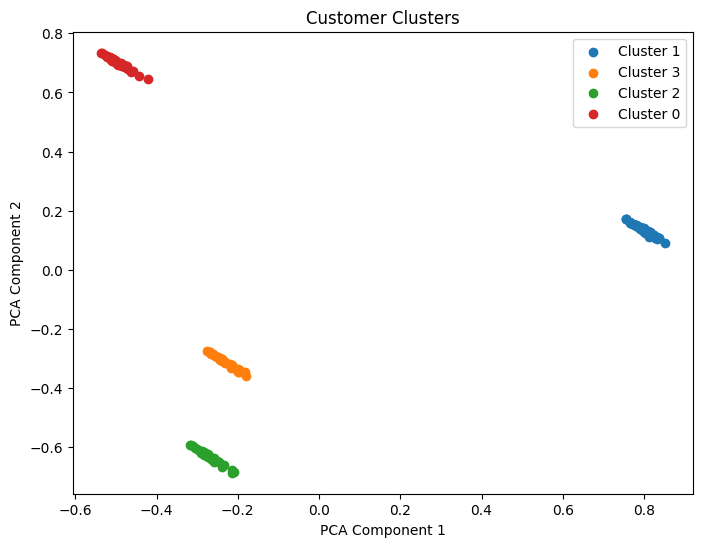

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Visualize clusters
plt.figure(figsize=(8, 6))
for cluster in final_data['Cluster'].unique():
    cluster_data = reduced_features[final_data['Cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.title('Customer Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [7]:
final_data.to_csv('Clustered_Customers.csv', index=False)
